# Preliminary Benchmarks for DOI functions on Progressive Visualization
This notebook contains the code to our benchmarks and for generating the figures we report on in the paper.
To run these benchmarks yourself, please follow the following steps first:

1. Follow the instructions in `prointerest/server/README.md` to install the python dependencies.
2. Follow the instructions in `prointerest/server/data/README.md` to download and preprocess the taxi dataset.
3. Notice that you **must** download this entire repository before running this  notebook (`benchmarks.ipynb`), and that this notebook also *must* be located inside the `prointerest/server/benchmarks/` directory in order to work properly.

You can now execute the cells of this notebook. Run the three scenarios (ground truth, baseline, our approach) first to generate the benchmark data as csv files, before visualizing the results.

## Ground truth: Monolithic DOI computation

In [9]:
from time import time
import os
from sys import path

cwd = os.getcwd()
path.append(f"{cwd}/..")

from doi_benchmark import *

N = 10**6

reset(intervals=INTERVALS, weights=WEIGHTS)
before = time()

df = get_next_chunk_from_db(N, as_df=True)
doi = compute_dois(df)

print(f"monolithic DOI computation: {time() - before}s")

ids = df[ID]

df["id"] = df[ID]
df["doi"] = doi

df.to_csv("monolithic.csv", index=False)

monolithic DOI computation: 97.43441724777222s


## Baseline: Progressive DOI without adaptations

In [16]:
from time import time
import os
from sys import path
import numpy as np

cwd = os.getcwd()
path.append(f"{cwd}/..")

from doi_benchmark import *


N = 10**6
CHUNK_SIZE = 1000
CONTEXT_SIZE = 0
N_CHUNKS = N // CHUNK_SIZE

storage_chunked = WindowingStorage(max_size=N)

reset(intervals=INTERVALS, weights=WEIGHTS)
timings = []

before_all = time()
for i in range(N_CHUNKS):
  before_chunk = time()
  chunk_df, new_dois = get_next_progressive_result(
      storage_chunked,
      chunk_size=CHUNK_SIZE,
      chunk_no=i,
  )
  timings += [time() - before_chunk]

print(f"chunk-based DOI computation: {time() - before_all}s")
print(f"median time per chunk: {np.median(timings)}s")

ids = storage_chunked.get_available_ids().tolist()

slice = (CHUNK_SIZE * N_CHUNKS) // 10
dois_chunked = pd.DataFrame([])

# duckdb query fails for all items in get_all_dois(), so get them in chunks ;)
for i in range(10):
  id_slice = ids[i*slice : (i+1)*slice]
  dois = storage_chunked.get_doi_for_ids(id_slice).astype(float)
  df = storage_chunked.get_items_for_ids(id_slice, as_df=True)
  df["id"] = id_slice
  df["doi"] = dois
  dois_chunked = pd.concat([dois_chunked, df], ignore_index=True)

dois_chunked.to_csv("chunked.csv", index=False)

chunk-based DOI computation: 1970.0537955760956s
median time per chunk: 2.0356041193008423s


## Progressive DOI with our model

In [17]:
from time import time
import os
from sys import path
import numpy as np

cwd = os.getcwd()
path.append(f"{cwd}/..")

from doi_benchmark import *


N = 10**6
CHUNK_SIZE = 1000
CONTEXT_SIZE = 2000
N_CHUNKS = N // CHUNK_SIZE

storage_model = WindowingStorage(max_size=N)

model = DoiRegressionModel(
    storage_model,
    max_depth=3,
    include_previous_chunks_in_training=False
)

reset(intervals=INTERVALS, weights=WEIGHTS)
timings = []

training_columns = ["tripID", "tip_amount", "trip_distance", "total_amount", "passenger_count"]

before_all = time()
for i in range(N_CHUNKS):
  before_chunk = time()
  # if no model exists, provide no context...
  if i == 0:
      chunk_df, new_dois = get_next_progressive_result(
          storage_model,
          chunk_size=CHUNK_SIZE,
          chunk_no=i,
      )

      model.update(chunk_df[training_columns], new_dois)
  # ... otherwise use model to provide context
  else:
      chunk_df, new_dois = get_next_progressive_result(
          storage_model,
          chunk_size=CHUNK_SIZE,
          chunk_no=i,
          get_context=lambda: model.get_context_items(CONTEXT_SIZE),
          model=model
      )

  model.update(chunk_df[training_columns], new_dois, update_outdated=True)
  timings += [time() - before_chunk]

print(f"chunk-based DOI computation: {time() - before_all}s")
print(f"median time per chunk: {np.median(timings)}s")


ids = storage_model.get_available_ids().tolist()

slice = (CHUNK_SIZE * N_CHUNKS) // 10
dois_model = pd.DataFrame([])

# duckdb query fails for all items in get_all_dois(), so get them in chunks ;)
for i in range(10):
  id_slice = ids[i*slice : (i+1)*slice]
  dois = storage_model.get_doi_for_ids(id_slice).astype(float)
  df = storage_model.get_items_for_ids(id_slice, as_df=True)
  df["id"] = id_slice
  df["doi"] = dois
  dois_model = pd.concat([dois_model, df], ignore_index=True)

dois_model.to_csv("model.csv", index=False)

chunk-based DOI computation: 2409.970556497574s
median time per chunk: 2.0636043548583984s


## Metrics

### (a) Top-k interesting items in visualization

our approach retrieved top k within 433 chunks


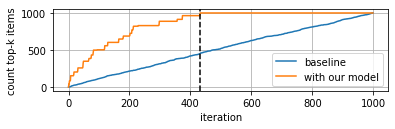

In [13]:
import os
import numpy as np
import pandas as pd


# first, make sure that the test cases have been computed
if not os.path.exists("monolithic.csv") or not os.path.exists("chunked.csv") or not os.path.exists("model.csv"):
  raise(FileNotFoundError("Please run all three test cases (ground truth, baseline, ours) before running this cell."))

monolithic_df = pd.read_csv("./monolithic.csv", index_col="id")
chunked_df = pd.read_csv("chunked.csv", index_col="id")
model_df = pd.read_csv("model.csv", index_col="id")

N = 10**6
CHUNK_SIZE = 1000
N_CHUNKS = N // CHUNK_SIZE
K = 1000

# sort data by the ground truth DOI
sort_by_doi_mono = np.argsort(monolithic_df["doi"])
sorted_df = monolithic_df.iloc[sort_by_doi_mono][::-1]

# get the top k ids
top_k_ids = sorted_df[:K].index

# group data by chunk number
model_df["chunk_no"] = np.arange(len(model_df)) // CHUNK_SIZE
chunked_df["chunk_no"] = np.arange(len(chunked_df)) // CHUNK_SIZE

# find number of top-k items per "chunk" per test case
top_k_in_chunk = []
top_k_in_model = []

for i in range(N_CHUNKS):
  ids_in_chunk = chunked_df[chunked_df["chunk_no"] <= i].index
  ids_in_model = model_df[model_df["chunk_no"] <= i].index

  top_k_in_chunk += [ids_in_chunk.isin(top_k_ids).sum()]
  top_k_in_model += [ids_in_model.isin(top_k_ids).sum()]

print(f"our approach retrieved top k within {top_k_in_model.index(K)+1} chunks")
ax = pd.DataFrame(np.array([top_k_in_chunk, top_k_in_model]).T, columns=["baseline", "with our model"]).plot(grid=True, figsize=(6, 1.5), xlabel="iteration", ylabel="count top-k items")
ax.axvline(x=top_k_in_model.index(K), c="black", linestyle="dashed")

items with error over 0.1: baseline: 59845 ours: 624


,baseline,with our model
count,896034.000000,896034.000000
mean,0.037550,0.017082
std,0.037950,0.010836
min,0.000083,-0.008972
25%,0.015838,0.009472
50%,0.025677,0.015639
75%,0.042928,0.022539
max,0.439771,0.392158


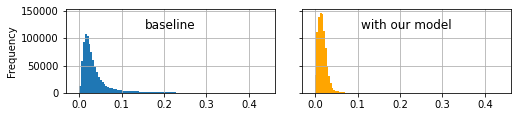

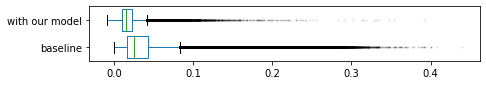

In [28]:
import os
import pandas as pd
from sys import path
import matplotlib.pyplot as plt

cwd = os.getcwd()
path.append(f"{cwd}/..")

fig, axes = plt.subplots(1, 2, figsize=(7, 1.75), sharex=True, sharey=True)
plt.tight_layout()

# first, make sure that the test cases have been computed
# first, make sure that the test cases have been computed
if not os.path.exists("monolithic.csv") or not os.path.exists("chunked.csv") or not os.path.exists("model.csv"):
  raise(FileNotFoundError("Please run all three test cases (ground truth, baseline, ours) before running this cell."))

# load the results
monolithic_df = pd.read_csv("monolithic.csv", index_col="id")
baseline_df = pd.read_csv("chunked.csv", index_col="id")
ours_df = pd.read_csv("model.csv", index_col="id")

# to get the "ground truth", join the two test cases with the monolithic run
joined_df = monolithic_df.join(baseline_df["doi"], how="inner", lsuffix="_mono", rsuffix="_baseline")
joined_df = joined_df.join(ours_df["doi"], how="inner")

# compute the error per test case compared to the monolithic run
joined_df["baseline"] = joined_df["doi_baseline"] - joined_df["doi_mono"]
joined_df["with our model"] = joined_df["doi"] - joined_df["doi_mono"]

df = joined_df[["baseline", "with our model"]]

# plot the distribution of doi error 
df["baseline"].plot.hist(bins=100, grid=True, ax=axes[0])
df["with our model"].plot.hist(bins=100, color="orange", grid=True, ax=axes[1])

# reposition title to remove whitespace
axes[0].set_title("baseline", loc='center', y=0.7)
axes[1].set_title("with our model", loc='center', y=0.7)

flierprops = dict(marker='.', markerfacecolor='black', markersize=2, linestyle='none', alpha=.1)

# summarize the doi error statistics as a boxplot
df[["baseline", "with our model"]].plot.box(figsize=(7, 1), widths=0.8, vert=False, showfliers=True, flierprops=flierprops)

baseline_count = len(df[df["baseline"] > 0.1])
ours_count = len(df[df["with our model"] > 0.1])
print("items with error over 0.1:", f"baseline: {baseline_count}", f"ours: {ours_count}")

# get some summary statistics (note that due to prioritization, our approach retrieves slightly 
# different items than the baseline, so count is not N but slightly lower due to join)
df.describe()

<br/>
<hr/>

## Additional Tests

### Training and querying times for interest model

In [21]:
from time import time
import os
from sys import path

cwd = os.getcwd()
path.append(f"{cwd}/..")

from doi_benchmark import *

N = 10**6
CHUNK_SIZE = 1000
CONTEXT_SIZE = 2000
N_CHUNKS = N // CHUNK_SIZE

# reset(intervals=INTERVALS, weights=WEIGHTS)

# df = get_next_chunk_from_db(N, as_df=True)

storage_model = WindowingStorage(max_size=N)

model = DoiRegressionModel(
    storage_model,
    max_depth=3,
    include_previous_chunks_in_training=False
)

training_times = []
query_times = []
training_columns = ["tripID", "tip_amount", "trip_distance", "total_amount", "passenger_count"]

for i in range(N_CHUNKS):
  chunk_df = df.iloc[i*CHUNK_SIZE : (i+1)*CHUNK_SIZE]
  before_training = time()

  model.update(chunk_df[training_columns], np.random.rand(CHUNK_SIZE))
  training_times += [time() - before_training]

  before_query = time()
  model.get_context_items(CONTEXT_SIZE)
  query_times += [time() - before_query]

stats = pd.DataFrame(np.array([training_times, query_times]).T, columns=["training time (in s)", "find supplemental items (in s)"])
stats.describe()

,training time (in s),find supplemental items (in s)
count,1000.000000,1000.000000
mean,0.003829,0.001942
std,0.000846,0.000737
min,0.001997,0.000840
25%,0.002996,0.001802
50%,0.003979,0.001994
75%,0.004026,0.002027
max,0.008976,0.009972


### Tree parameters

In [ ]:
import os
from sys import path

cwd = os.getcwd()
path.append(f"{cwd}/..")

from doi_benchmark import Benchmark


def benchmark_max_depth(tested_max_depths: range = range(1, 10)):
  '''Measures how varying `max_depth` parameter influences progressive DOI prediction scores, over 
  a series of chunks (without retraining) --- how stable/overfitted is the tree model.'''
  benchmark = Benchmark(max_depths=tested_max_depths)
  scores = benchmark.run()
  return scores


def benchmark_retraining_intervals(tested_intervals: range = range(25)):
  '''Measures how varying the update interval influences progressive DOI prediction scores.'''
  benchmark = Benchmark(intervals=tested_intervals)
  scores = benchmark.run()
  return scores


def benchmark_chunk_size(tested_sizes: range = range(1000, 110000, 10000)):
  '''Measures how varying the chunk size influences the progressive DOI prediction scores (without
   retraining, without context)'''
  benchmark = Benchmark(chunk_size=tested_sizes)
  scores = benchmark.run()
  return scores


def benchmark_context_size(tested_sizes: range = range(0, 11000, 1000)):
  '''Measures how varying the context size influences the progressive DOI prediction scores (without
   retraining)'''
  benchmark = Benchmark(context_size=tested_sizes)
  scores = benchmark.run()
  return scores


def benchmark_context_strategies(context_strats=["stratified", "minmax"]):
  benchmark = Benchmark(n_chunks=50, context_size=500, intervals=50, measure_doi_error=True, context_strats=context_strats)
  scores = benchmark.run()

  return scores


def benchmark_doi_error_without_context():
  '''Measures the changes in DOI error throughout the progression, when no optimizations are 
   applied.'''
  benchmark = Benchmark(n_chunks=100, chunk_size=1000, measure_doi_error=True)
  scores = benchmark.run()

  return scores

  
def benchmark_doi_error_with_context():
  '''Measures the changes in DOI error throughout the progression, when context optimizations are 
   applied.'''
  benchmark = Benchmark(n_chunks=100, chunk_size=1000, measure_doi_error=True, context_size=1000, intervals=5, context_strats="stratified")
  scores = benchmark.run()

  return scores

def benchmark_retraining_strategies():
  '''Measures the changes in DOI error throughout the progression, when context is applied by simply predicting the DOI'''

  benchmark = Benchmark(n_chunks=10, chunk_size=1000, context_size=1000, intervals=5, measure_doi_error=True, measure_timings=True, include_previous_chunks_in_training=[True, False])
  scores = benchmark.run()

  return scores, benchmark

def benchmark_with_without_model():
  '''Measures the impact of using vs. not using the regression tree model for computing the user interest.'''
  benchmark = Benchmark(measure_doi_error=True)

  scores = benchmark.run()
  return scores, benchmark

# results: max_depth = 3 has best peformance, then no improvement/worse for bigger values
max_depth_results = benchmark_max_depth()

# results: trivial best results for 0 and 1, score std for 3-8 above 0.9 
intervals_results = benchmark_retraining_intervals()

# results: the larger the context the worse the scores.
context_size_results = benchmark_context_size()

# results: the larger the chunk size, the better the scores
chunk_size_results = benchmark_chunk_size()

# results: minmax worse than stratified sampling
context_strategies_results = benchmark_context_strategies()

# results: overall error increases with every chunk -> DOI values "age"
doi_error_without_context_results = benchmark_doi_error_without_context()

# results: error increases over time but not as badly as without the context and it gets better
doi_error_with_context_results = benchmark_doi_error_with_context()

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

doi_error_with_context_results[~doi_error_with_context_results["include_previous_chunks_in_training"]].plot(x="chunk", y="error_mean", ax=axes[0])
doi_error_with_context_results[doi_error_with_context_results["include_previous_chunks_in_training"]].plot(x="chunk", y="error_mean", ax=axes[1])

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(10, 5), sharey=True)

doi_error_with_context_results.boxplot(column="score", by="include_previous_chunks_in_training", ax=axes[0])

doi_error_with_context_results[~doi_error_with_context_results["include_previous_chunks_in_training"]].plot(y="score", x="chunk", ax=axes[1])

doi_error_with_context_results[doi_error_with_context_results["include_previous_chunks_in_training"]].plot(y="score", x="chunk", ax=axes[2])

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True, sharex=True)

doi_error_without_context_results["error_std"].plot(ax=axes[0])
doi_error_with_context_results["error_std"].plot(ax=axes[1])

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

context_strategies_results.boxplot(column="error_std", by="context_strat", ax=axes[0])
context_strategies_results.plot(y="error_std", x="chunk",  ax=axes[1])


In [ ]:
max_depth_results.boxplot(column="score", by="max_depth")

In [ ]:
intervals_results.boxplot(column="score", by="interval")

In [ ]:
context_size_results.boxplot(column="score", by="context_size")

In [ ]:
chunk_size_results.boxplot(column="score", by="chunk_size")